In [1]:
import conf

conf done!


<div class="maintitle">
    <h2> Métodos Multicriterio Orientados al Tratamiento Automático de Datos</h2>
    <h3 class="subtitle">Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
    <span>FaMAF-UNC, 2022 </span>
</div>

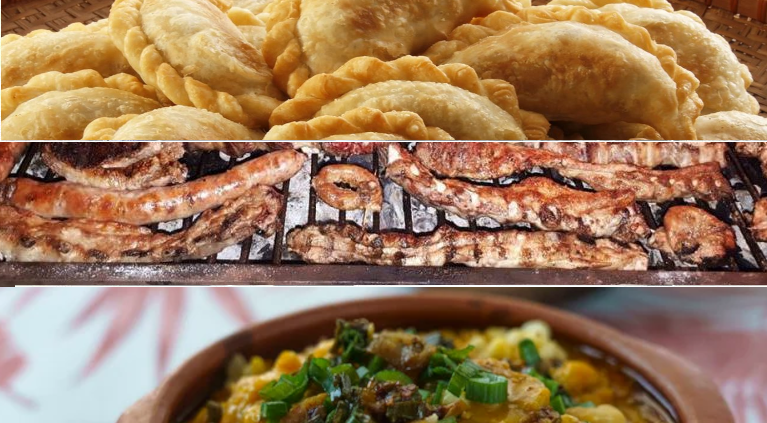

**Docentes:**
- Dr. Juan B Cabral (FaMAF-UNC, CONAE, IATE-OAC-CONICET)
- Mg. Nadia Luczywo (FCE-UNC)

## Clase 2

- Calculo automático de pesos: Desvio, Entropía y CRITIC.
- Metodos basados en similaridad TOPSIS.
- Escuela Francesa: ELECTRE-I, ELECTRE-II
- Comparando resultados.
- SKCriteria internals.


## Calculo automático de pesos

- Los pesos *son* meter sesgos a los criterios de tal forma, representen las preferencias de un descisor.
- En un mundo ideal (y en el caso de pocos datos) seria bueno que los que "paguen" por la decision sean los que proveean esos pesos.
- La realidad es otra (y sobre todo como analista/cientifico de datos):

    1. Los datos que se encuentran en internet suelen tener bastante mas dimensionalidad que unos pocos criterios.
    2. Es naive asumir que todos los criterios tienen la misma importancia.
    3. No siempre se dispone de un experto.

## Nota 1:

- Algunas librerias manejan el concepto de "*weights/profit*" vs "*cost*". 
- SKCriteria utiliza unicamente "weights/profit" en cooncordancia de que se prefiere $maximizar$.

## Nota 2:

- Es recomendable asignar pesos de manera automatica en dos lugares:
    - **justo antes** de ejecutar la funcion de agregación.
    - **justo antes** de empezar a masajear los datos.

## El ejemplo

Vamos a usar el mismo ejemplo de la clase 1.

In [11]:
import skcriteria as skc
from skcriteria import datasets

dm = datasets.load_simple_stock_selection()
dm

,ROE[▲ 2.0],CAP[▲ 4.0],RI[▼ 1.0]
PE,7,5,35
JN,5,4,26
AA,5,6,28
FX,3,4,36
MM,1,7,30
GN,5,8,30


Ahora pongamos todos los pesos en `1` para empezar a jugar

In [12]:
dm = dm.copy(weights=[1, 1, 1])
dm

,ROE[▲ 1.0],CAP[▲ 1.0],RI[▼ 1.0]
PE,7,5,35
JN,5,4,26
AA,5,6,28
FX,3,4,36
MM,1,7,30
GN,5,8,30


## `skcriteria.preprocessing.weighters`

El modulo `weighters` posee transformadores para alterar de manera automática los pesos

Los implementados son:

- `EqualWeighter`: Aproach naive - Todos los pesos iguales.
- `StdWeighter`: Buscar cual es el peso que mas explica los datos.
- `EntropyWeighter`: El criterio con mas información.
- `Critic`: Lo vemo' ma' adelante.


In [13]:
from skcriteria.preprocessing import weighters

## `skcriteria.preprocessing.weighters.EqualWeighter`

- Es el aproach naive, de asignar el mismo peso a todos los criterios.
- Simplemente acepta un valor `base_value` y lo divide por la cantidad de criterios.
- Obviamente: `base_value=1` (valor por defecto) es lo mismo que poner cualquier valor y normalizarlo por la suma.

In [25]:
wght = weighters.EqualWeighter()
wght

EqualWeighter(base_value=1.0)

In [26]:
wght.transform(dm)

,ROE[▲ 0.333333],CAP[▲ 0.333333],RI[▼ 0.333333]
PE,7,5,35
JN,5,4,26
AA,5,6,28
FX,3,4,36
MM,1,7,30
GN,5,8,30


## `skcriteria.preprocessing.weighters.StdWeighter`

- El criterio mas disperso es el más importante.
- Utiliza el desvio estandar por criterio como valor del peso.

$$w_j = \frac{s_j}{\sum{s}}$$

Donde:
- $s_j$ Es el devio muestral de cada criterio $j$.
- $\sum{s}$ es la sum de todos los $s_j$.

In [47]:
from skcriteria.preprocessing import invert_objectives
wght = weighters.Critic()
wght

Critic(correlation=<function pearson_correlation at 0x7fc86c352ef0>, scale=True)

In [50]:
weighters.critic_weights??

In [48]:
wght.transform(dm), wght.transform(invert_objectives.CriMinimize().transform(dm))

/home/juanbc/proyectos/skcriteria/src/skcriteria/preprocessing/weighters.py:396: UserWarning: Although CRITIC can operate with minimization objectives, this is not recommended. Consider reversing the weights for these cases.
  warnings.warn(


(    ROE[▲ 0.337001]  CAP[▲ 0.352684]  RI[▼ 0.310315]
 PE                7                5              35
 JN                5                4              26
 AA                5                6              28
 FX                3                4              36
 MM                1                7              30
 GN                5                8              30
 [6 Alternatives x 3 Criteria],
     ROE[▲ 0.327652]  CAP[▲ 0.362739]  RI[▲ 0.309610]
 PE                7                5        0.028571
 JN                5                4        0.038462
 AA                5                6        0.035714
 FX                3                4        0.027778
 MM                1                7        0.033333
 GN                5                8        0.033333
 [6 Alternatives x 3 Criteria])

## Technique for Order Preference by Similarity to Ideal Solution (TOPSIS)

- Se basa en el concepto de que es deseable que una alternativa determinada se ubique a la distancia más corta respecto de una solución ideal y a la mayor distancia respecto a una solución anti-ideal.
- El procedimiento consta de una serie de pasos que permiten calcular un proporción llamado “ratio de similaridad” que valora el desempeño de cada alternativa.
- Es compensatorio.
- Se sugiere normalizar con el módulo del vector.
- Muy intuitivo y transparente.
- Si bien acepta múltiples medidas de distancia suele utilizarse la euclídea.
- Tolera los criterios de minimización.

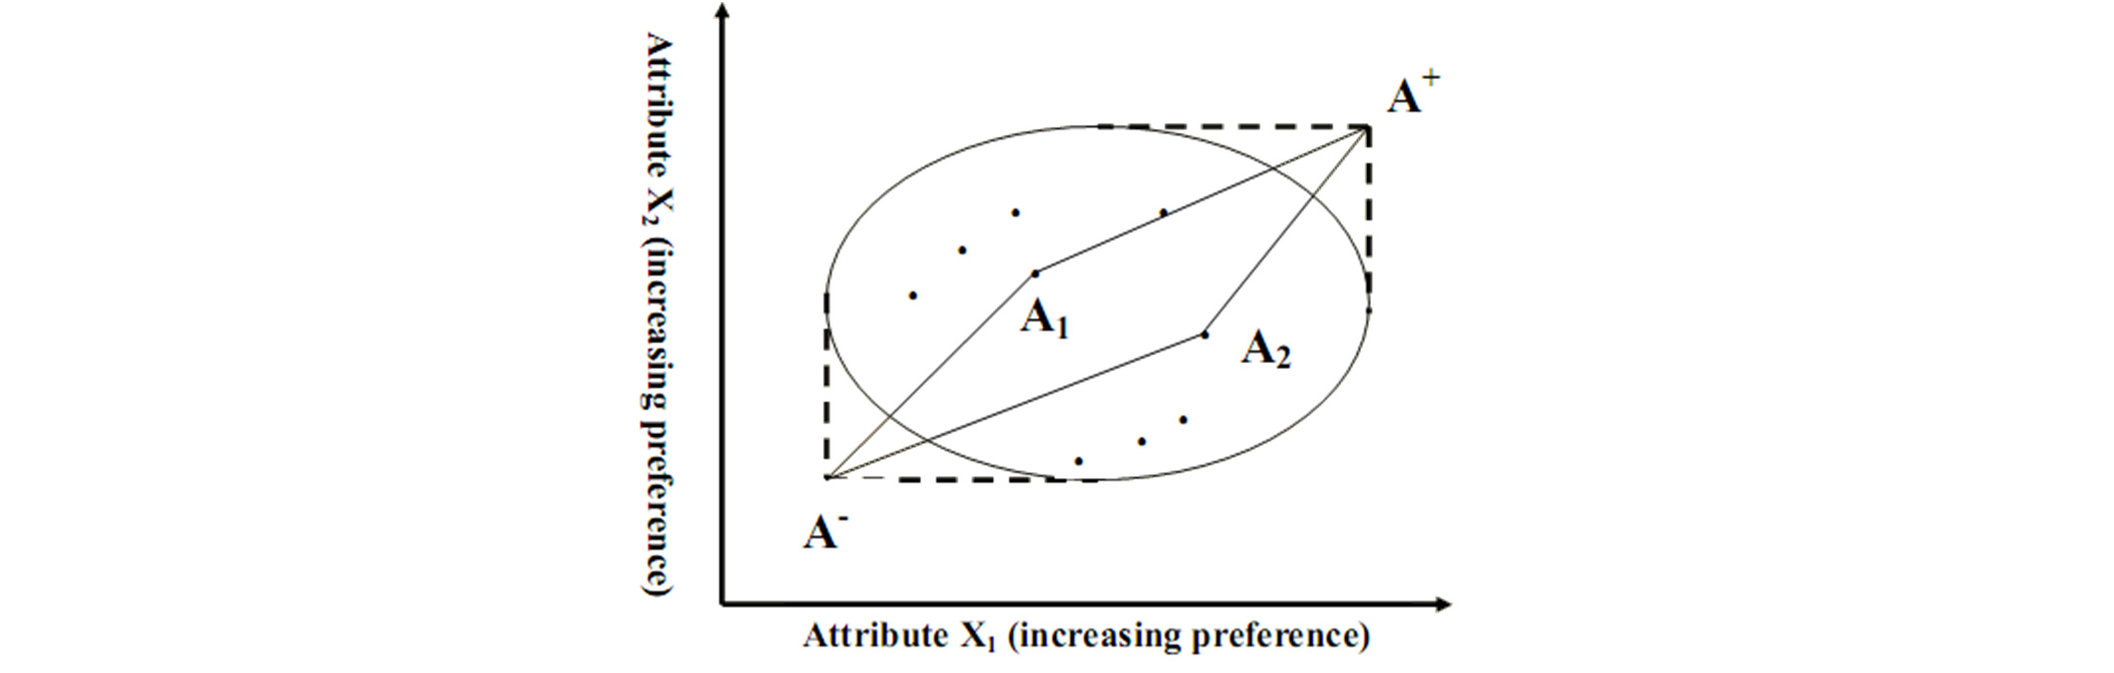

## TOPSIS - SKCriteria

Como pueden realizarse diferentes experimentos variando las funciones de agregación o normalizaciones; skcriteria proevee el concepto de *pipelines*.

In [4]:
from skcriteria.preprocessing.scalers import VectorScaler
from skcriteria.pipeline import mkpipe
from skcriteria.madm.similarity import TOPSIS 

In [5]:
pipe = mkpipe(
    MinimizeToMaximize(), 
    SumScaler(target="weights"), 
    VectorScaler(target="matrix"), 
    TOPSIS()
)
pipe

NameError: name 'MinimizeToMaximize' is not defined

## TOPSIS - SKCriteria

In [ ]:
result = pipe.evaluate(dm)
result

In [ ]:
result.e_.ideal, result.e_.anti_ideal

In [ ]:
pipe.transform(dm)

## ÉLimination et Choix Traduisant la REalité (ELECTRE) - SKCriteria

- Es una familia de métodos de la "escuela francesa".
- Son métodos no compensarios.
- Diseñan internamente indices de superación entre las alternativas.
- En particular ELECTRE1, no resuelve un ranking sino un kernel.


In [ ]:
from skcriteria.madm.electre import ELECTRE1

pipe = mkpipe(
    MinimizeToMaximize(), 
    SumScaler(target="weights"), 
    VectorScaler(target="matrix"), 
    ELECTRE1()
)

In [ ]:
result = pipe.evaluate(dm)
result

In [ ]:
result.e_.matrix_discordance

## Que quedo fuera de MCDA.

- Calculo automático de pesos (esto tiene skcriteria).
- Análisis de sensibilidad y robustez.
- Ranking reversals.
- Métodos Fuzzy.

## Algunos trabajos

- Somma, D., Volante, J., Lizárraga, L., Boasso, M., Mosciaro, M. J., Poclava, M. M., ... & Ramos, J. (2011). **Aplicación de análisis multicriterio-multiobjetivo como base de un sistema espacial de soporte de decisiones para la planificación del uso sustentable del territorio en regiones forestales. caso de estudio: los bosques nativos de la provincia de salta.** Valoración de servicios ecosistémicos. Conceptos, herramientas y aplicaciones para el ordenamiento territorial. INTA, Buenos Aires, Argentina, 409-440.
- Van Heerden, N. A., Cabral, J. B., & Luczywo, N. (2021). **Evaluation of the importance of criteria for the selection of cryptocurrencies.** arXiv preprint arXiv:2109.00130.


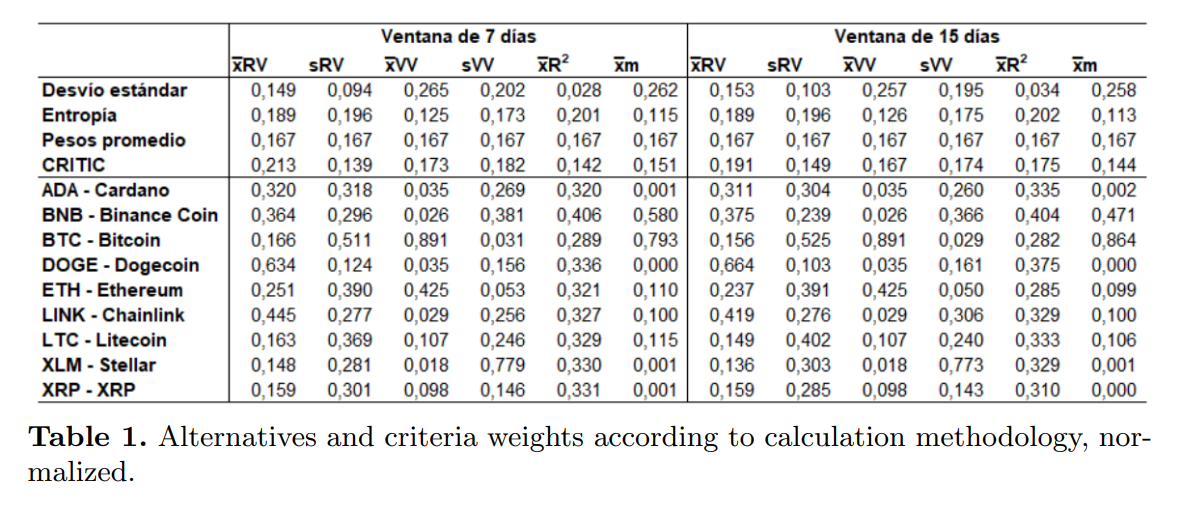

## Cerrando

- Los metodos MCDA son muy transparentes.
- Sistematizan una serie de problemas de manera muy sencilla.
- El area puede interactuar muy bien con toda la bateria de "cosas" de ciencias de datos.
- Da un marco de analisis al proceso de toma de decisiones por parte de algun experto.
- Esto esta a un paso del *análisis envolvente de datos* (DEA).

## GRACIAS.

Juan - jbcabral@unc.edu.ar

In [ ]:
ax = dmt.plot.box();
ax.set_title("Mirá, mirá! tengo un plot");